In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import cv2

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 60
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set the dataset path in Google Drive
# Change this path to where your dataset folder is stored in your Drive
DATA_PATH = '/content/drive/MyDrive/Tea Leaf Updated'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


In [ ]:
data_dir = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_PATH,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
)

Found 2497 files belonging to 4 classes.


In [ ]:
class_names = data_dir.class_names
print(f"Class names: {class_names}")
print(f"Dataset len: {len(data_dir)}")

Class names: ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']
Dataset len: 79


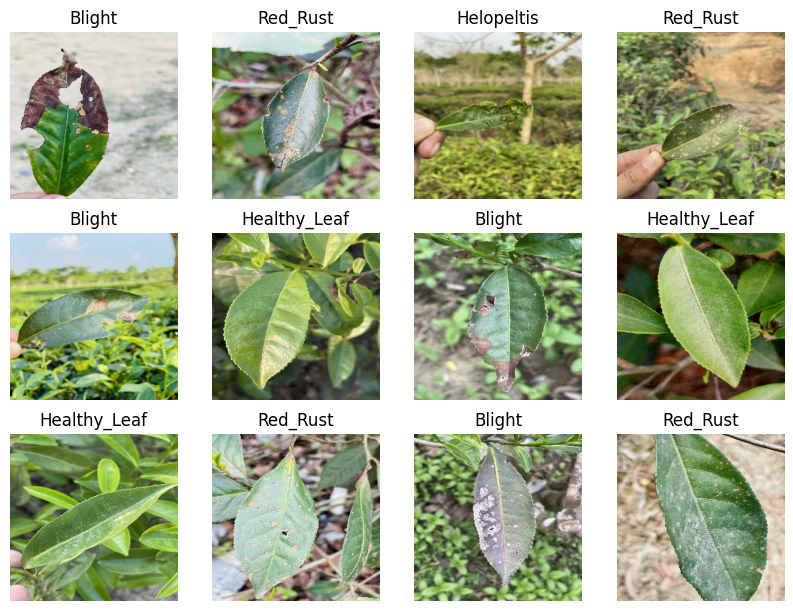

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in data_dir.take(2):
    for i in range(12):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [ ]:
# Data loading and preprocessing
def load_data(data_dir, img_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """Load and preprocess data from directory"""
    images = []
    labels = []
    class_names = ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: {class_path} not found")
            continue

        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]

        print(f"Loading {len(image_files)} images from {class_name}")

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype(np.float32) / 255.0

                images.append(img)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels), class_names

In [ ]:
X, y, class_names = load_data(DATA_PATH)

Loading 555 images from Blight
Loading 650 images from Healthy_Leaf
Loading 675 images from Helopeltis
Loading 617 images from Red_Rust


In [ ]:
print(f"Total samples: {len(X)}")
print(f"Image shape: {X.shape}")
print(f"Classes: {class_names}")

Total samples: 2497
Image shape: (2497, 256, 256, 3)
Classes: ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']


In [ ]:
# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("\nClass distribution:")
for i, (class_idx, count) in enumerate(zip(unique, counts)):
    print(f"{class_names[class_idx]}: {count} samples")


Class distribution:
Blight: 555 samples
Healthy_Leaf: 650 samples
Helopeltis: 675 samples
Red_Rust: 617 samples


In [ ]:
# Split data: 80% train, 10% val, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTrain samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Train samples: 1997
Validation samples: 250
Test samples: 250


In [ ]:
# Data augmentation for training
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    # brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# No augmentation for validation and test
val_datagen = keras.preprocessing.image.ImageDataGenerator()

In [ ]:
# Create data generators
batch_size = BATCH_SIZE
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)
test_generator = val_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

print(f"\nTrain generator batches: {len(train_generator)}")
print(f"Validation generator batches: {len(val_generator)}")
print(f"Test generator batches: {len(test_generator)}")


Train generator batches: 63
Validation generator batches: 8
Test generator batches: 8


In [ ]:
# Custom CNN Model
def create_tea_leaf_model(input_shape=(256, 256, 3), num_classes=5):
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
# Create and compile model
model = create_tea_leaf_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Model summary
model.summary()
print(f"Total parameters: {model.count_params():,}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

Total parameters: 183,877


In [ ]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False
    )
]

In [ ]:
# Training
print("\nStarting training...")
history = model.fit(
    train_generator,
    #steps_per_epoch=len(X_train) // batch_size,
    epochs=EPOCHS,
    validation_data=val_generator,
    #validation_steps=len(X_val) // batch_size,
    callbacks=callbacks,
    verbose=1
)



Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.2989 - loss: 1.4293

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 557ms/step - accuracy: 0.2989 - loss: 1.4283 - val_accuracy: 0.3880 - val_loss: 1.1167 - learning_rate: 0.0010
Epoch 2/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.4454 - loss: 1.1314

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 447ms/step - accuracy: 0.4455 - loss: 1.1316 - val_accuracy: 0.4320 - val_loss: 1.1186 - learning_rate: 0.0010
Epoch 3/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.4877 - loss: 1.0915

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 453ms/step - accuracy: 0.4879 - loss: 1.0909 - val_accuracy: 0.5000 - val_loss: 1.0450 - learning_rate: 0.0010
Epoch 4/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.5320 - loss: 1.0305

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 445ms/step - accuracy: 0.5327 - loss: 1.0296 - val_accuracy: 0.6600 - val_loss: 0.8654 - learning_rate: 0.0010
Epoch 5/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 452ms/step - accuracy: 0.6545 - loss: 0.8696 - val_accuracy: 0.6240 - val_loss: 0.9677 - learning_rate: 0.0010
Epoch 6/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.6894 - loss: 0.7839

63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - accuracy: 0.6894 - loss: 0.7839 - val_accuracy: 0.6840 - val_loss: 0.8170 - learning_rate: 0.0010
Epoch 7/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.7093 - loss: 0.7521

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - accuracy: 0.7094 - loss: 0.7519 - val_accuracy: 0.6880 - val_loss: 0.7372 - learning_rate: 0.0010
Epoch 8/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.7314 - loss: 0.6809

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.7317 - loss: 0.6804 - val_accuracy: 0.7160 - val_loss: 0.7070 - learning_rate: 0.0010
Epoch 9/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - accuracy: 0.7814 - loss: 0.5804 - val_accuracy: 0.7120 - val_loss: 0.7402 - learning_rate: 0.0010
Epoch 10/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.7817 - loss: 0.6038

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - accuracy: 0.7818 - loss: 0.6032 - val_accuracy: 0.8120 - val_loss: 0.4546 - learning_rate: 0.0010
Epoch 11/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - accuracy: 0.7916 - loss: 0.5582 - val_accuracy: 0.7640 - val_loss: 0.6696 - learning_rate: 0.0010
Epoch 12/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 464ms/step - accuracy: 0.8207 - loss: 0.4972 - val_accuracy: 0.7760 - val_loss: 0.6023 - learning_rate: 0.0010
Epoch 13/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8164 - loss: 0.4726

63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 470ms/step - accuracy: 0.8164 - loss: 0.4729 - val_accuracy: 0.8160 - val_loss: 0.4822 - learning_rate: 0.0010
Epoch 14/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - accuracy: 0.8358 - loss: 0.4559 - val_accuracy: 0.8040 - val_loss: 0.5037 - learning_rate: 0.0010
Epoch 15/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8322 - loss: 0.4165

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.8324 - loss: 0.4166 - val_accuracy: 0.8280 - val_loss: 0.4516 - learning_rate: 0.0010
Epoch 16/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8499 - loss: 0.4214

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 460ms/step - accuracy: 0.8499 - loss: 0.4214 - val_accuracy: 0.8480 - val_loss: 0.4113 - learning_rate: 0.0010
Epoch 17/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - accuracy: 0.8620 - loss: 0.3914 - val_accuracy: 0.8240 - val_loss: 0.4709 - learning_rate: 0.0010
Epoch 18/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - accuracy: 0.8549 - loss: 0.3943 - val_accuracy: 0.7640 - val_loss: 0.7346 - learning_rate: 0.0010
Epoch 19/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8596 - loss: 0.3941

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 460ms/step - accuracy: 0.8596 - loss: 0.3942 - val_accuracy: 0.8520 - val_loss: 0.3919 - learning_rate: 0.0010
Epoch 20/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 465ms/step - accuracy: 0.8664 - loss: 0.3800 - val_accuracy: 0.8520 - val_loss: 0.4127 - learning_rate: 0.0010
Epoch 21/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8800 - loss: 0.3592

63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 448ms/step - accuracy: 0.8800 - loss: 0.3588 - val_accuracy: 0.9040 - val_loss: 0.3272 - learning_rate: 0.0010
Epoch 22/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - accuracy: 0.8856 - loss: 0.3525 - val_accuracy: 0.8480 - val_loss: 0.4740 - learning_rate: 0.0010
Epoch 23/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 453ms/step - accuracy: 0.8909 - loss: 0.3012 - val_accuracy: 0.8960 - val_loss: 0.3014 - learning_rate: 0.0010
Epoch 24/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 461ms/step - accuracy: 0.8899 - loss: 0.3045 - val_accuracy: 0.9000 - val_loss: 0.3583 - learning_rate: 0.0010
Epoch 25/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - accuracy: 0.9040 - loss: 0.2851 - val_accuracy: 0.8600 - val_loss: 0.3822 - learning_rate: 0.0010
Epoch 26/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - accuracy: 0.9036 - loss: 0.2813 - val_accuracy: 0.8560 - val_loss: 0.4530 - learning_rate: 0.0010
Epoch 27/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 460ms/step - accuracy: 0.9029 - loss: 0.2560 

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - accuracy: 0.9161 - loss: 0.2381 - val_accuracy: 0.9120 - val_loss: 0.2604 - learning_rate: 5.0000e-04
Epoch 31/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - accuracy: 0.9185 - loss: 0.2417 - val_accuracy: 0.8880 - val_loss: 0.3048 - learning_rate: 5.0000e-04
Epoch 32/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - accuracy: 0.9185 - loss: 0.2244 - val_accuracy: 0.8920 - val_loss: 0.3020 - learning_rate: 5.0000e-04
Epoch 33/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - accuracy: 0.9340 - loss: 0.2032 - val_accuracy: 0.8920 - val_loss: 0.2912 - learning_rate: 5.0000e-04
Epoch 34/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 452ms/step - accuracy: 0.9347 - loss: 0.1956 - val_accuracy: 0.8880 - val_loss: 0.2798 - learning_rate: 5.0000e-04
Epoch 35/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - accuracy: 0.9236 - loss: 0.2044 - val_accuracy: 0.9080 - val_loss: 0.2568 - learning_rate: 5.0000e-04
Epoch 36/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 466ms/step - accuracy

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - accuracy: 0.9399 - loss: 0.1938 - val_accuracy: 0.9240 - val_loss: 0.2297 - learning_rate: 5.0000e-04
Epoch 38/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 468ms/step - accuracy: 0.9437 - loss: 0.1584 - val_accuracy: 0.9000 - val_loss: 0.2465 - learning_rate: 5.0000e-04
Epoch 39/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 474ms/step - accuracy: 0.9484 - loss: 0.1434 - val_accuracy: 0.8800 - val_loss: 0.2716 - learning_rate: 5.0000e-04
Epoch 40/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 474ms/step - accuracy: 0.9240 - loss: 0.1946 - val_accuracy: 0.9240 - val_loss: 0.2222 - learning_rate: 5.0000e-04
Epoch 41/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 483ms/step - accuracy: 0.9450 - loss: 0.1586 - val_accuracy: 0.8920 - val_loss: 0.3367 - learning_rate: 5.0000e-04
Epoch 42/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 471ms/step - accuracy: 0.9395 - loss: 0.1688 - val_accuracy: 0.9200 - val_loss: 0.2353 - learning_rate: 5.0000e-04
Epoch 43/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 464ms/step - accuracy

63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 475ms/step - accuracy: 0.9571 - loss: 0.1213 - val_accuracy: 0.9360 - val_loss: 0.1794 - learning_rate: 2.5000e-04
Epoch 54/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 478ms/step - accuracy: 0.9678 - loss: 0.0893 - val_accuracy: 0.9280 - val_loss: 0.1966 - learning_rate: 2.5000e-04
Epoch 55/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 470ms/step - accuracy: 0.9577 - loss: 0.0993 - val_accuracy: 0.9320 - val_loss: 0.2198 - learning_rate: 2.5000e-04
Epoch 56/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 475ms/step - accuracy: 0.9582 - loss: 0.1031 - val_accuracy: 0.9280 - val_loss: 0.2664 - learning_rate: 2.5000e-04
Epoch 57/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 481ms/step - accuracy: 0.9622 - loss: 0.1056 - val_accuracy: 0.9200 - val_loss: 0.2155 - learning_rate: 2.5000e-04
Epoch 58/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9637 - loss: 0.1022

63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 480ms/step - accuracy: 0.9637 - loss: 0.1022 - val_accuracy: 0.9440 - val_loss: 0.2229 - learning_rate: 2.5000e-04
Epoch 59/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 479ms/step - accuracy: 0.9663 - loss: 0.0953 - val_accuracy: 0.9400 - val_loss: 0.2058 - learning_rate: 1.2500e-04
Epoch 60/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 471ms/step - accuracy: 0.9669 - loss: 0.0929 - val_accuracy: 0.9280 - val_loss: 0.1828 - learning_rate: 1.2500e-04


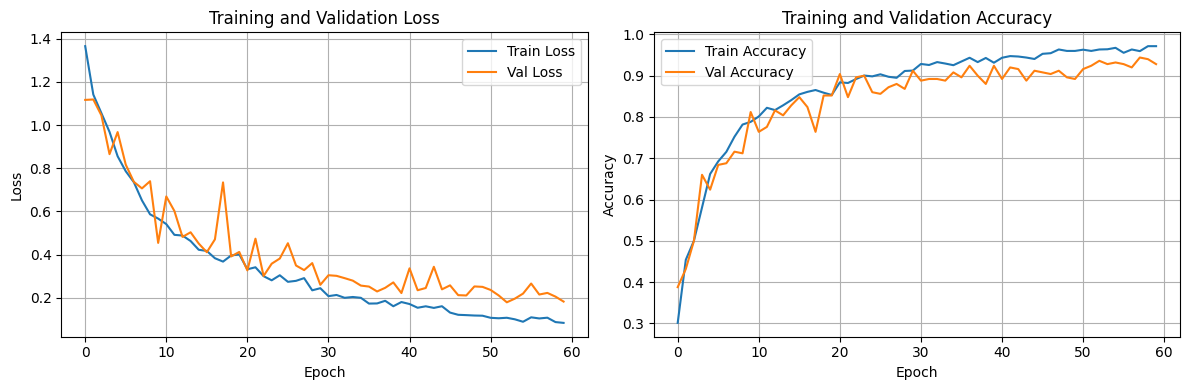

In [ ]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

class_names = ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_val

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
Classification Report:

              precision    recall  f1-score   support

      Blight     0.8772    0.9091    0.8929        55
Healthy_Leaf     0.9692    0.9692    0.9692        65
  Helopeltis     0.9420    0.9559    0.9489        68
    Red_Rust     0.9492    0.9032    0.9256        62

    accuracy                         0.9360       250
   macro avg     0.9344    0.9344    0.9342       250
weighted avg     0.9366    0.9360    0.9361       250



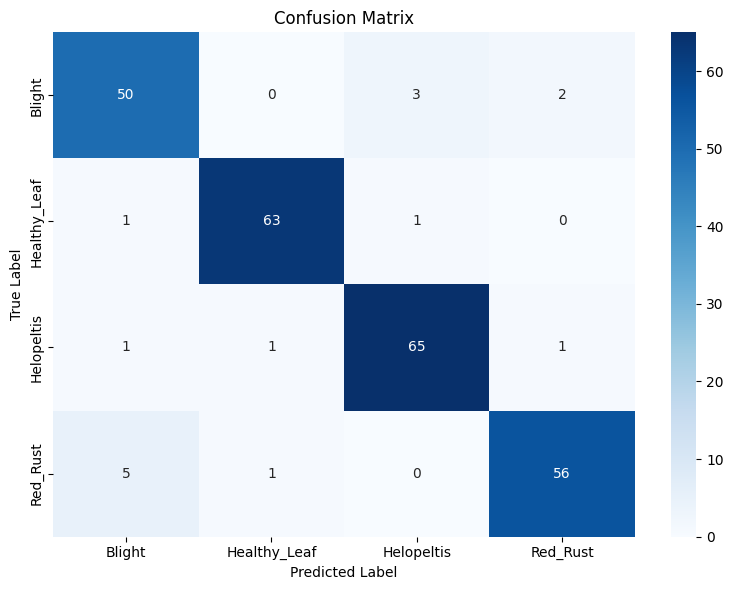

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


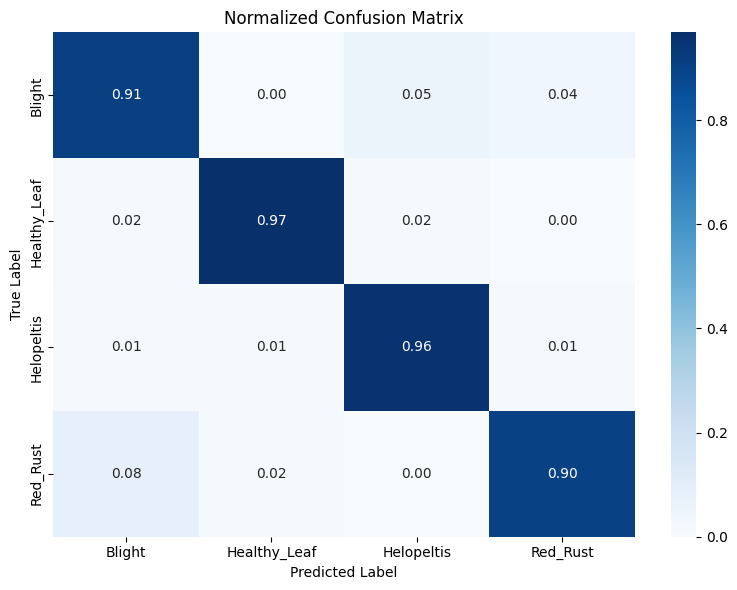

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix (raw values):\n", cm_normalized)


Normalized Confusion Matrix (raw values):
 [[0.90909091 0.         0.05454545 0.03636364]
 [0.01538462 0.96923077 0.01538462 0.        ]
 [0.01470588 0.01470588 0.95588235 0.01470588]
 [0.08064516 0.01612903 0.         0.90322581]]


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix row-wise
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Convert to pandas DataFrame for nice printing with class labels
df_cm = pd.DataFrame(cm_normalized, index=class_names, columns=class_names)

print("Normalized Confusion Matrix:\n")
print(df_cm)


Normalized Confusion Matrix:

                Blight  Healthy_Leaf  Helopeltis  Red_Rust
Blight        0.909091      0.000000    0.054545  0.036364
Healthy_Leaf  0.015385      0.969231    0.015385  0.000000
Helopeltis    0.014706      0.014706    0.955882  0.014706
Red_Rust      0.080645      0.016129    0.000000  0.903226


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix (raw counts)
cm = confusion_matrix(y_true, y_pred)

# Convert to pandas DataFrame for pretty printing with class labels
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

print("Confusion Matrix (Raw Counts):\n")
print(df_cm)


Confusion Matrix (Raw Counts):

              Blight  Healthy_Leaf  Helopeltis  Red_Rust
Blight            50             0           3         2
Healthy_Leaf       1            63           1         0
Helopeltis         1             1          65         1
Red_Rust           5             1           0        56


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


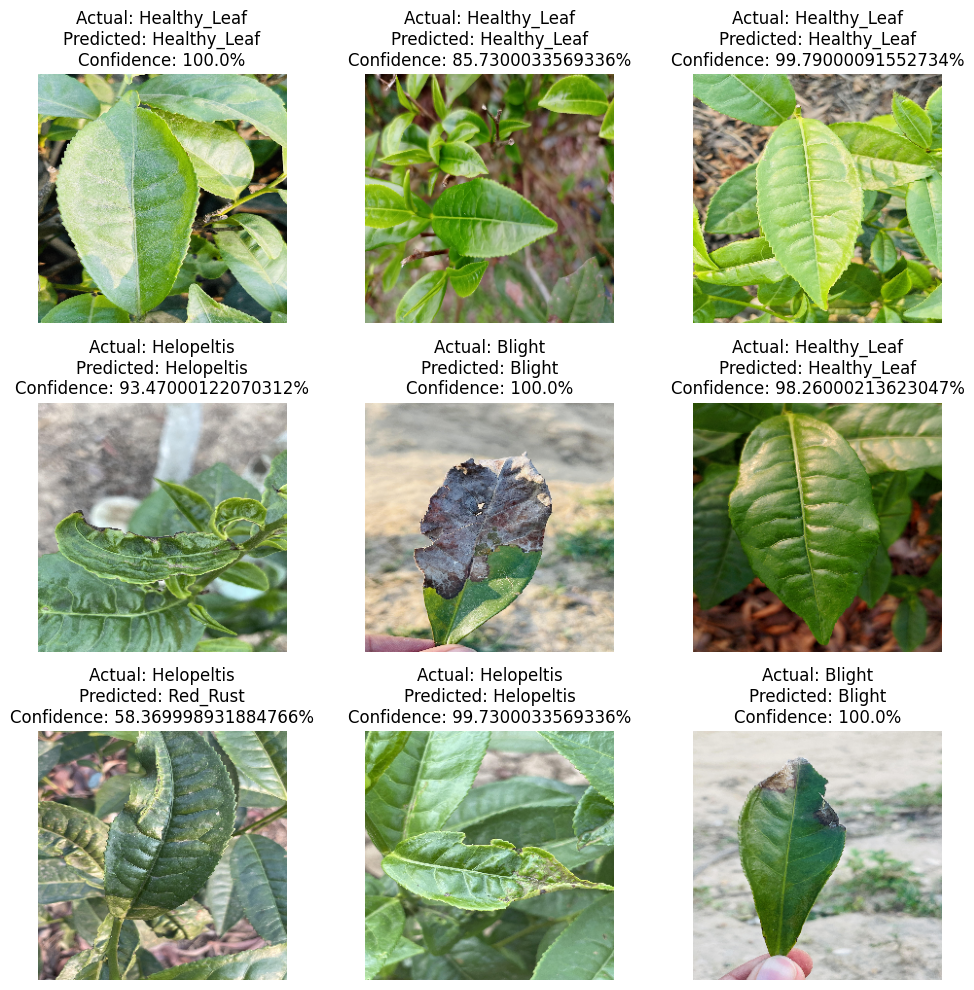

In [ ]:

class_names = ['Blight', 'Healthy_Leaf', 'Helopeltis', 'Red_Rust']
def predict(model, img):
    img_array = tf.expand_dims(img, 0)  # Add batch dimension
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * np.max(prediction[0]), 2)
    return predicted_class, confidence

# Get one batch from test_generator
images, labels = next(test_generator)

# Plot 9 images with predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)

    # Denormalize the image
    img = (images[i] * 255).astype("uint8")

    # Get actual and predicted classes
    actual_class = class_names[int(labels[i])]
    predicted_class, confidence = predict(model, images[i])

    plt.imshow(img)
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
    plt.axis("off")

plt.tight_layout()
plt.show()


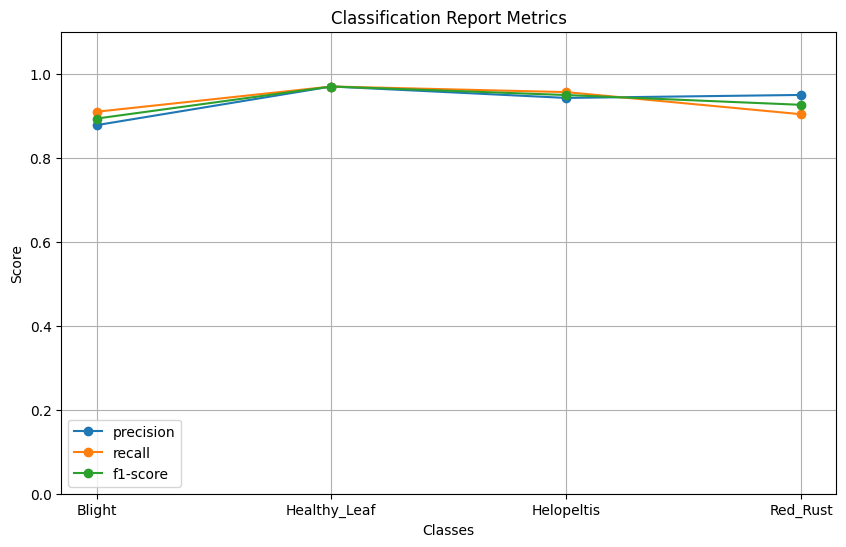

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']
plt.figure(figsize=(10,6))

for metric in metrics:
    scores = [report[cls][metric] for cls in class_names]
    plt.plot(class_names, scores, marker='o', label=metric)

plt.ylim(0, 1.1)
plt.title("Classification Report Metrics")
plt.xlabel("Classes")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


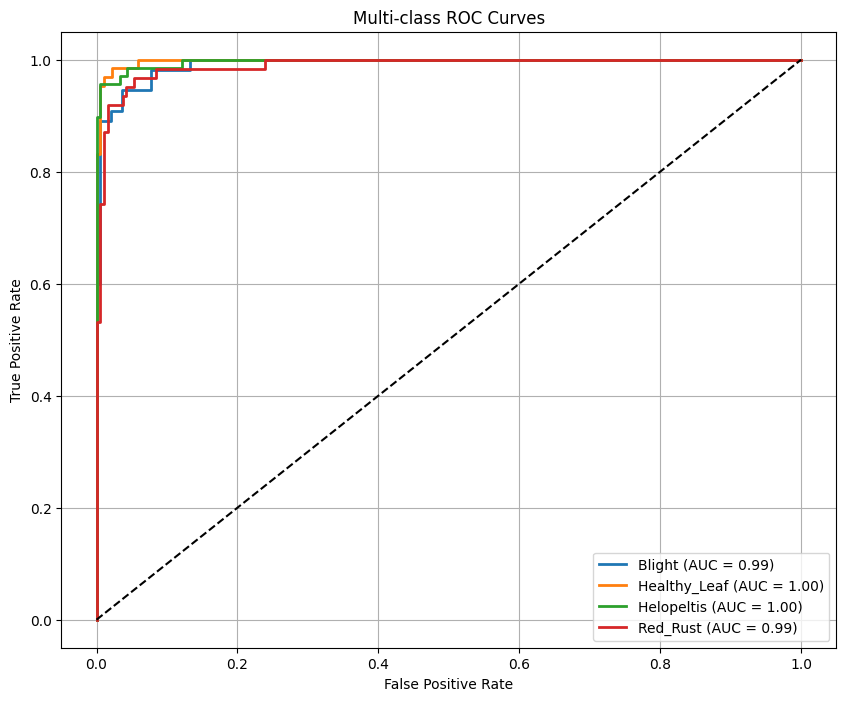

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize true labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

# Predict probabilities
y_pred_prob = model.predict(X_val)

plt.figure(figsize=(10,8))

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # random guess line
plt.title('Multi-class ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


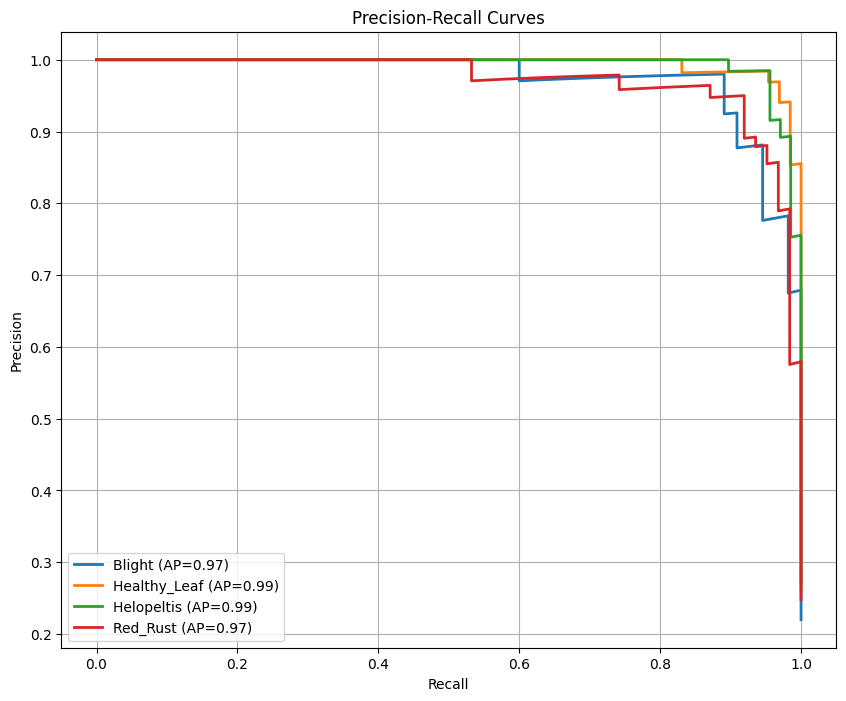

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10,8))

for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_name} (AP={ap:.2f})')

plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
